In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [2]:
path = '../data/opm_rich/Task/raw_preproc.fif'
raw = mne.io.read_raw_fif(path, preload=True)
raw_old = mne.io.read_raw_fif(path, preload=True)

<ipython-input-2-d8e967b7cdd0>:2: RuntimeWarning: This filename (../data/opm_rich/Task/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)
<ipython-input-2-d8e967b7cdd0>:3: RuntimeWarning: This filename (../data/opm_rich/Task/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_old = mne.io.read_raw_fif(path, preload=True)


In [9]:
lang_channels = ['LR', 'LF', 'LE', 'KG', 'LM', 'KI', 'KF', 'K9',
                 'FR', 'FV', 'FU', 'FS', 'G2', 'G0', 'HQ', 'HE', 'FX']

# extract indices from raw.ch_names if lang_channels name is in the string of raw.ch_names
lang_indices = [i for i, s in enumerate(raw.ch_names) if any(xs in s for xs in lang_channels)]

In [11]:
len(np.array(lang_indices))

45

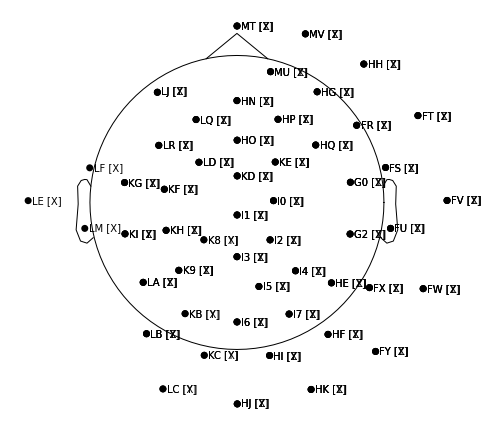

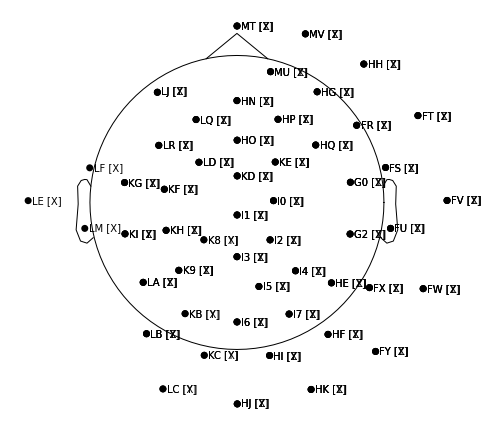

In [3]:
raw.plot_sensors(show_names=True)

In [3]:
channels = pd.read_csv('../data/opm_rich/Task/20220908_115229_channels.tsv', sep='\t')

In [4]:
# get Ox, Oy, Oz orientations from channels.tsv based on raw.ch_names
Ox = channels.loc[channels['name'].isin(raw.ch_names), 'Ox'].values
Oy = channels.loc[channels['name'].isin(raw.ch_names), 'Oy'].values
Oz = channels.loc[channels['name'].isin(raw.ch_names), 'Oz'].values

ors = np.vstack((Ox, Oy, Oz)).T

In [5]:
# eye(length(ors)) - ors*pinv(ors)
eye = np.eye(len(ors))
pinv = np.linalg.pinv(ors)
mfc = eye - ors @ pinv

In [6]:
# apply mfc to the raw object through raw.apply_function()
fun = lambda x: mfc @ (x - np.mean(x, axis=1, keepdims=True))
raw.apply_function(fun, channel_wise=False)

<Raw | raw_preproc.fif, 146 x 2320680 (1933.9 s), ~2.52 GB, data loaded>

In [39]:
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,9')

In [23]:
raw.save('../data/opm_rich/Task/raw_preproc_mfc.fif', overwrite=True)

<ipython-input-23-e4c6a61cd81e>:1: RuntimeWarning: This filename (/gpfs2/well/woolrich/users/yaq921/MEG-transfer-decoding/data/opm_rich/Task/raw_preproc_mfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('../data/opm_rich/Task/raw_preproc_mfc.fif', overwrite=True)


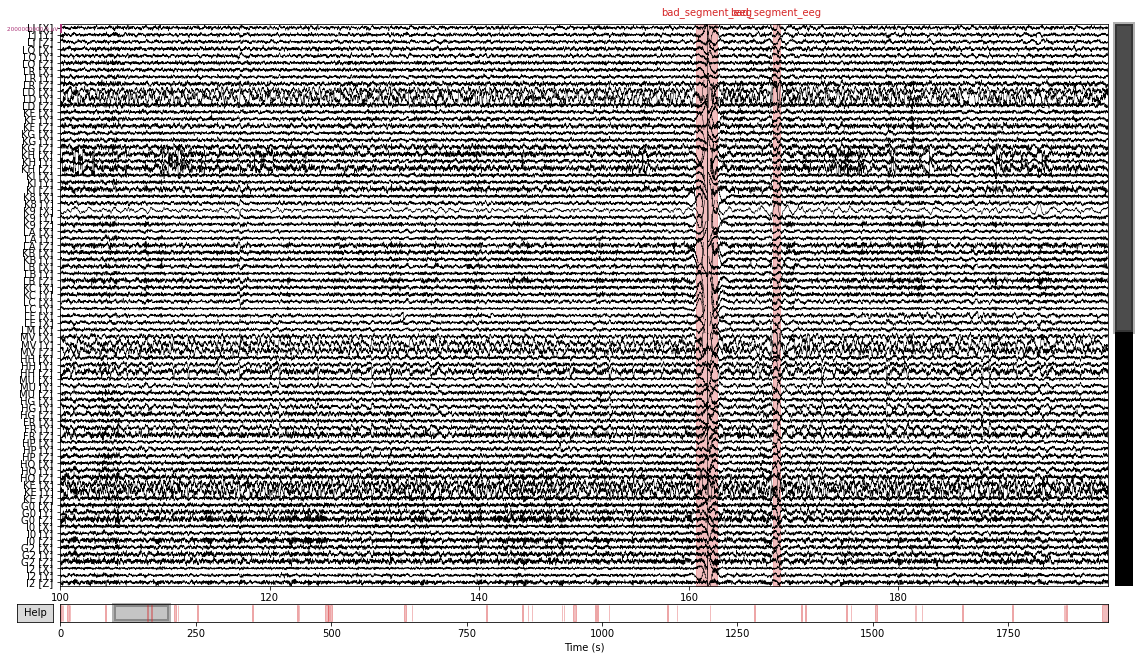

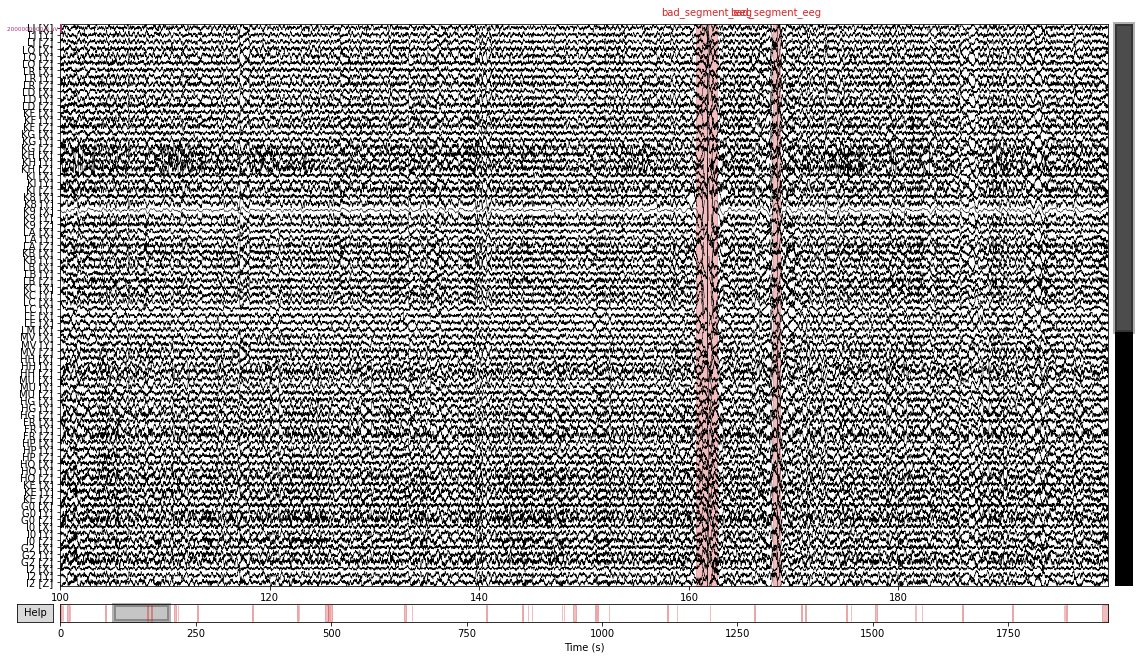

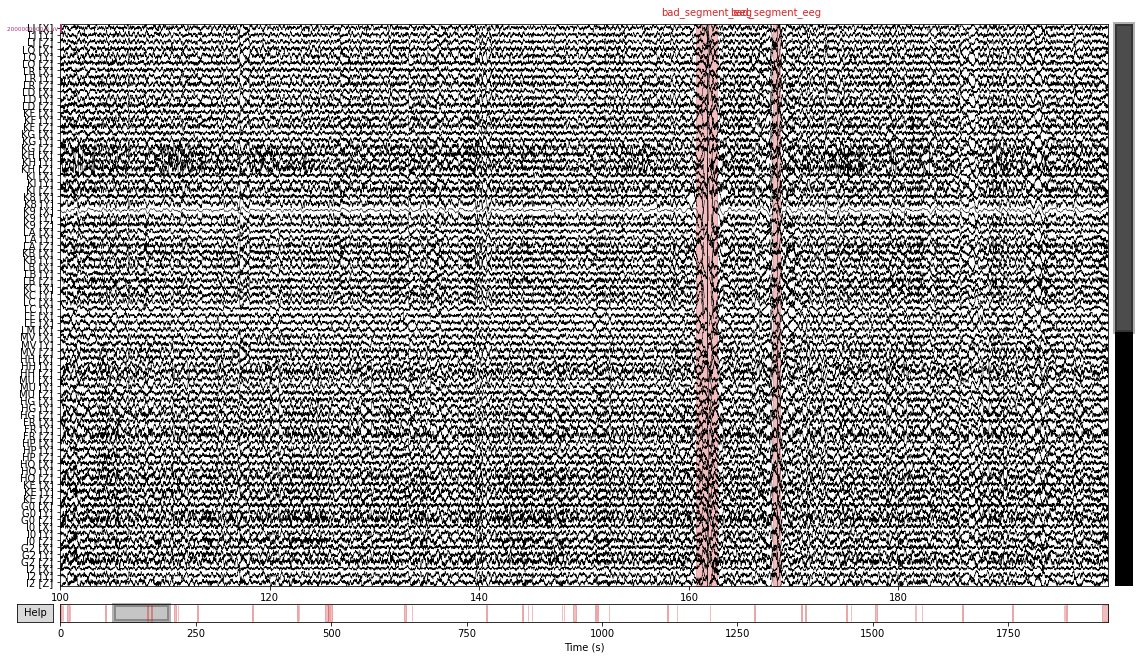

In [22]:
# check whether the mfc is applied correctly
%matplotlib inline
raw.plot(n_channels=80, start=100, duration=100, scalings=dict(eeg=1e3))
raw_old.plot(n_channels=80, start=100, duration=100, scalings=dict(eeg=1e3))